<h1><center>筆記備註：</center></h1>
資料集共：24000

訓練集：外部保留測試集 = 22800:1200 (9.5:0.5)

訓練集再分為，訓練集與內部測試集 =15959:6841 (7:3)

程式碼流程：

1.用訓練集15959人初始建模，可初步評估各演算法效能。

2.此時已可直接預測6841人的內部測試集的驗證結果。(ROC、cm BALALA)

3.從第一點為base，再加入6841人retrain，可得到6841人的內部測試集的驗證結果，此時結果將更好。(ROC、cm BALALA)

4.最終驗證1200人的純外部保留集。(※Pycaret內部畫圖套件似乎綁定訓練時的模型與資料，純外來資料預測時，各圖需自行提取數值後用其他套件繪出(先得到sen、spe再經由計算繪製ROC))

5.完畢後，即可匯出模型，並且陌生使用(※同上)。

<h1><center>Install Pycaret</center></h1>

In [8]:
!pip install --user pycaret[full]

<h1><center>準備一個Dataframe (dataset)</center></h1>

In [21]:
from pycaret.datasets import get_data
dataset = get_data('credit')
print(dataset.shape)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,90000,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,50000,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,50000,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,50000,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


(24000, 24)


In [22]:
#dataset 全部資料 ; data_unseen 外部測試集 ; data 訓練集(訓練&內部測試)

data = dataset.sample(frac=0.95, random_state=786)              #抽95%(24000*0.95=22800)作訓練集
data_unseen = dataset.drop(data.index)                          #drop掉這95%(24000-22800=1200)，剩餘5%作外部測試集

data.reset_index(inplace=True, drop=True)                       #訓練集重新reset index
data_unseen.reset_index(inplace=True, drop=True)                #測試集重新reset index

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (22800, 24)
Unseen Data For Predictions: (1200, 24)


In [23]:
#setup() 函數在 pycaret 中初始化環境並創建轉換管道來為建模和部署準備數據。
#setup() 必須在 pycaret 中執行任何其他函數 "之前" 調用。
#setup() 需要兩個強制性參數：pandas df 和 目標y名稱。
from pycaret.classification import *

#訓練:內部測試集 = 15959:6841
exp_clf101 = setup(data = data, target = 'default',train_size=0.7, session_id=123) #session_id 預設即是123 #train_size預設是0.7

,Description,Value
0,session_id,123
1,Target,default
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(22800, 24)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


<h1><center>全預設跑全部模型(訓練集15959人)</center></h1>

In [24]:
# best_model = compare_models(sort = 'Recall') #由Recall排序結果
# best_model = compare_models(fold = 5)     #五倍交叉驗證
best_model = compare_models() #預設是準確度排序、十倍交叉驗證

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8254,0.0000,0.3637,0.6913,0.4764,0.3836,0.4122,0.0220
lda,Linear Discriminant Analysis,0.8247,0.7634,0.3755,0.6794,0.4835,0.3884,0.4132,0.1030
gbc,Gradient Boosting Classifier,0.8227,0.7790,0.3551,0.6813,0.4666,0.3728,0.4014,1.3000
ada,Ada Boost Classifier,0.8221,0.7697,0.3505,0.6811,0.4626,0.3690,0.3983,0.3140
catboost,CatBoost Classifier,0.8216,0.7771,0.3643,0.6691,0.4716,0.3753,0.4006,3.1870
lightgbm,Light Gradient Boosting Machine,0.8210,0.7750,0.3609,0.6679,0.4683,0.3721,0.3977,0.1610
rf,Random Forest Classifier,0.8185,0.7622,0.3608,0.6544,0.4649,0.3664,0.3901,0.5330
xgboost,Extreme Gradient Boosting,0.8160,0.7561,0.3629,0.6391,0.4626,0.3617,0.3829,1.7510
et,Extra Trees Classifier,0.8090,0.7396,0.3715,0.6031,0.4593,0.3513,0.3667,0.5750
lr,Logistic Regression,0.7814,0.6410,0.0003,0.1000,0.0006,0.0003,0.0034,0.1440


<h1><center>Pycaret有提供的model</center></h1>

In [25]:
models() #Pycaret提供的model

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


<h1><center>預設跑單個模型(訓練集15959人)</center></h1>

In [26]:
dt = create_model('dt')
print(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7337,0.6294,0.4441,0.4016,0.4218,0.2494,0.2499
1,0.7393,0.6322,0.4384,0.4102,0.4238,0.2556,0.2559
2,0.7393,0.6246,0.4212,0.4072,0.4141,0.2465,0.2466
3,0.7268,0.6062,0.3926,0.3795,0.3859,0.2103,0.2104
4,0.7193,0.6161,0.4327,0.3766,0.4027,0.2204,0.2213
5,0.7155,0.5963,0.3811,0.3585,0.3694,0.1860,0.1862
6,0.7318,0.6239,0.4327,0.3963,0.4137,0.2403,0.2407
7,0.7343,0.5953,0.3496,0.3824,0.3653,0.1977,0.1980
8,0.7180,0.5988,0.3868,0.3639,0.3750,0.1932,0.1933
9,0.7398,0.6254,0.4224,0.4072,0.4147,0.2475,0.2475


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')


In [27]:
# knn = create_model('knn',fold=5) #五倍交叉驗證
knn = create_model('knn')          #預設為十倍，index0~10 分別為每回驗證
print(knn)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7469,0.6020,0.1920,0.3545,0.2491,0.1128,0.1204
1,0.7550,0.5894,0.2092,0.3883,0.2719,0.1402,0.1500
2,0.7506,0.5883,0.1576,0.3459,0.2165,0.0923,0.1024
3,0.7419,0.5818,0.1519,0.3136,0.2046,0.0723,0.0790
4,0.7563,0.5908,0.1490,0.3611,0.2110,0.0954,0.1085
5,0.7550,0.5997,0.1748,0.3720,0.2378,0.1139,0.1255
6,0.7638,0.5890,0.1891,0.4125,0.2593,0.1413,0.1565
7,0.7613,0.6240,0.1633,0.3904,0.2303,0.1163,0.1318
8,0.7619,0.5988,0.1862,0.4037,0.2549,0.1356,0.1500
9,0.7549,0.5756,0.1897,0.3771,0.2524,0.1246,0.1351


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


In [28]:
rf = create_model('rf')
print(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8102,0.7669,0.3553,0.6139,0.4501,0.3451,0.3639
1,0.8289,0.7636,0.3897,0.6939,0.4991,0.4056,0.4302
2,0.8214,0.7725,0.3352,0.6882,0.4509,0.3590,0.3922
3,0.8227,0.7694,0.3811,0.6650,0.4845,0.3868,0.4087
4,0.8170,0.7623,0.3467,0.6541,0.4532,0.3555,0.3814
5,0.8264,0.7722,0.3926,0.6782,0.4973,0.4013,0.4232
6,0.8095,0.7626,0.3438,0.6154,0.4412,0.3373,0.3581
7,0.8252,0.7428,0.3639,0.6902,0.4765,0.3835,0.4118
8,0.8089,0.7466,0.3410,0.6134,0.4383,0.3343,0.3552
9,0.8144,0.7628,0.3592,0.6313,0.4579,0.3560,0.3766


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


<h1><center>自動條整參數(訓練集15959人)</center></h1>

In [29]:
# tuned_dt = tune_model(dt, optimize = 'AUC') #可自動檢索AUC最高的參數組合 
tuned_dt = tune_model(dt) #預設採Accuracy最高的參數組合
print(tuned_dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8177,0.7475,0.3095,0.6835,0.4260,0.3355,0.3728
1,0.8289,0.7711,0.3381,0.7375,0.4637,0.3782,0.4190
2,0.8208,0.7377,0.2894,0.7266,0.4139,0.3305,0.3796
3,0.8252,0.7580,0.3152,0.7333,0.4409,0.3563,0.4010
4,0.8195,0.7545,0.3095,0.6968,0.4286,0.3398,0.3794
5,0.8271,0.7509,0.3438,0.7186,0.4651,0.3769,0.4134
6,0.8195,0.7488,0.3123,0.6943,0.4308,0.3415,0.3801
7,0.8246,0.7529,0.2980,0.7482,0.4262,0.3446,0.3957
8,0.8195,0.7241,0.3123,0.6943,0.4308,0.3415,0.3801
9,0.8188,0.7378,0.3075,0.6903,0.4254,0.3362,0.3751


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')


In [30]:
import numpy as np
tuned_knn = tune_model(knn, custom_grid = {'n_neighbors' : np.arange(0,50,1)})
print(tuned_knn)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7813,0.6482,0.0372,0.5000,0.0693,0.0402,0.0876
1,0.7807,0.6436,0.0315,0.4783,0.0591,0.0330,0.0759
2,0.7744,0.6563,0.0315,0.3333,0.0576,0.0206,0.0403
3,0.7845,0.6589,0.0659,0.5610,0.1179,0.0754,0.1345
4,0.7826,0.6645,0.0315,0.5500,0.0596,0.0368,0.0903
5,0.7794,0.6477,0.0544,0.4634,0.0974,0.0539,0.0961
6,0.7826,0.6278,0.0630,0.5238,0.1125,0.0688,0.1214
7,0.7751,0.6702,0.0372,0.3611,0.0675,0.0278,0.0523
8,0.7813,0.6409,0.0630,0.5000,0.1120,0.0662,0.1146
9,0.7881,0.6426,0.0661,0.6389,0.1198,0.0822,0.1548


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=42, p=2,
                     weights='uniform')


In [31]:
tuned_rf = tune_model(rf)
print(tuned_rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8158,0.7508,0.3181,0.6647,0.4302,0.3363,0.3689
1,0.8283,0.7675,0.3295,0.7419,0.4563,0.3719,0.4152
2,0.8139,0.7337,0.3181,0.6529,0.4277,0.3321,0.3628
3,0.8246,0.7588,0.3095,0.7347,0.4355,0.3514,0.3976
4,0.8170,0.7567,0.3438,0.6557,0.4511,0.3539,0.3805
5,0.8258,0.7513,0.3324,0.7205,0.4549,0.3676,0.4067
6,0.8170,0.7529,0.3324,0.6629,0.4427,0.3474,0.3771
7,0.8221,0.7507,0.3381,0.6901,0.4538,0.3621,0.3951
8,0.8177,0.7201,0.2980,0.6933,0.4168,0.3286,0.3699
9,0.8213,0.7485,0.3161,0.7006,0.4356,0.3471,0.3860


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                       criterion='entropy', max_depth=5, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


<h1><center>模型效能評估(內部測試集6841人)</center></h1>

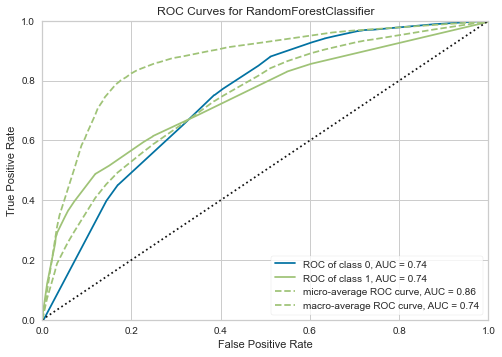

In [32]:
# micro將匯總所有類的貢獻以計算平均度量(不同集合的單個真陽性、假陽性和假陰性相加)
# macro平均獨立計算每個類的度量，然後取平均值（只取不同集合上的準確率和召回率的平均值）
plot_model(tuned_rf, plot = 'auc')

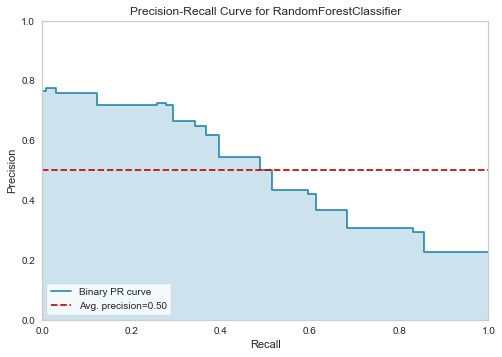

In [33]:
#PR Curve用於查看精度（真陽性的數量佔陽性總數 - 真陽性和假陽性的總和）和召回率（真陽性的數量佔真實真值總數 - 真陽性的數量之間的關係和假陰性相結合）
plot_model(tuned_rf, plot = 'pr')

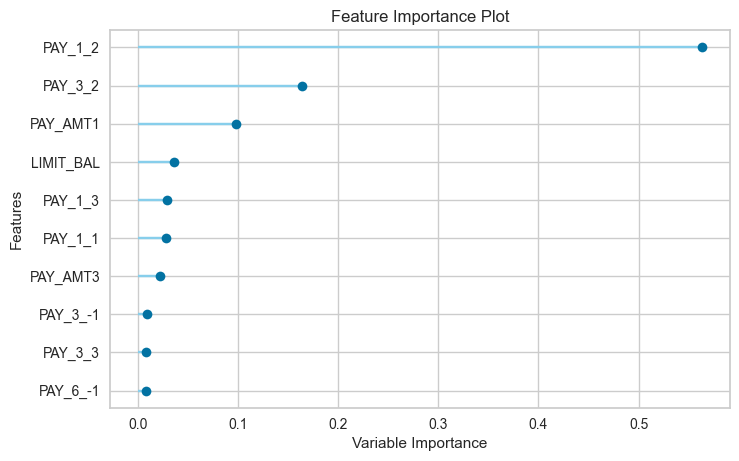

In [34]:
#Feature Importance Plot(特徵重要性圖)
plot_model(tuned_rf, plot='feature')

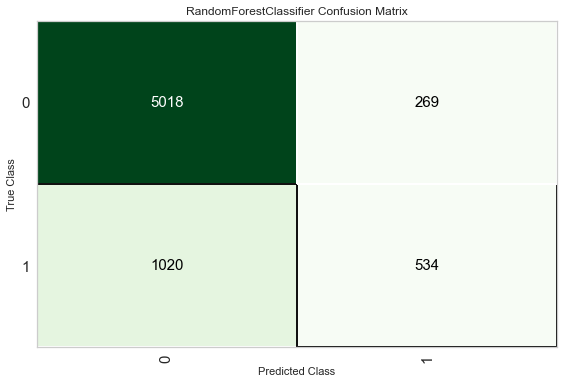

In [35]:
#混淆矩陣
plot_model(tuned_rf, plot = 'confusion_matrix')

In [53]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [40]:
predict_model(tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8116,0.7407,0.3436,0.6650,0.4531,0.3530,0.3811


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,default,Label,Score
0,80000.0,29.0,6228.0,589.0,390.0,390.0,390.0,383.0,589.0,390.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8452
1,180000.0,30.0,149069.0,152317.0,156282.0,161163.0,172190.0,148963.0,7500.0,8000.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.9201
2,100000.0,26.0,18999.0,23699.0,9390.0,5781.0,8065.0,17277.0,5129.0,1227.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9201
3,500000.0,36.0,396.0,1043.0,19230.0,116696.0,194483.0,195454.0,1043.0,19230.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8452
4,190000.0,47.0,192493.0,193297.0,193400.0,193278.0,192956.0,193039.0,7200.0,7222.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6836,120000.0,44.0,75294.0,76465.0,74675.0,79629.0,77748.0,82497.0,3000.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.5649
6837,50000.0,26.0,47095.0,48085.0,49039.0,49662.0,0.0,0.0,2073.0,2027.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8394
6838,80000.0,39.0,46401.0,39456.0,30712.0,29629.0,28241.0,28030.0,1560.0,1421.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8452
6839,200000.0,33.0,50612.0,10537.0,5552.0,2506.0,9443.0,11818.0,10023.0,27.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7548


In [39]:
#將產生預測結果Label，Score預測概率分數
predict_model(tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8116,0.7407,0.3436,0.6650,0.4531,0.3530,0.3811


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,default,Label,Score
0,80000.0,29.0,6228.0,589.0,390.0,390.0,390.0,383.0,589.0,390.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8452
1,180000.0,30.0,149069.0,152317.0,156282.0,161163.0,172190.0,148963.0,7500.0,8000.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.9201
2,100000.0,26.0,18999.0,23699.0,9390.0,5781.0,8065.0,17277.0,5129.0,1227.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9201
3,500000.0,36.0,396.0,1043.0,19230.0,116696.0,194483.0,195454.0,1043.0,19230.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8452
4,190000.0,47.0,192493.0,193297.0,193400.0,193278.0,192956.0,193039.0,7200.0,7222.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6836,120000.0,44.0,75294.0,76465.0,74675.0,79629.0,77748.0,82497.0,3000.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.5649
6837,50000.0,26.0,47095.0,48085.0,49039.0,49662.0,0.0,0.0,2073.0,2027.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8394
6838,80000.0,39.0,46401.0,39456.0,30712.0,29629.0,28241.0,28030.0,1560.0,1421.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8452
6839,200000.0,33.0,50612.0,10537.0,5552.0,2506.0,9443.0,11818.0,10023.0,27.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7548


<h1><center>加入內部測試集retrain整個資料集</center></h1>

In [41]:
final_rf = finalize_model(tuned_rf)
print(final_rf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                       criterion='entropy', max_depth=5, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


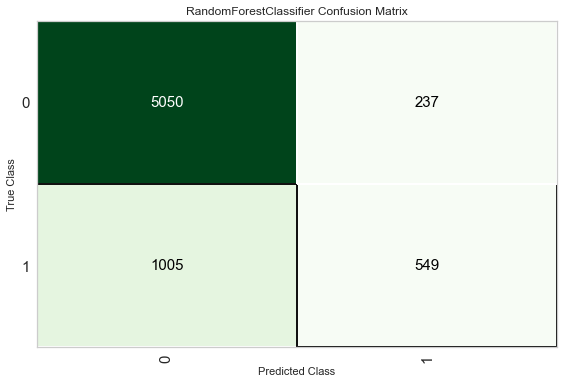

In [42]:
plot_model(final_rf, plot = 'confusion_matrix')

In [43]:
#將產生預測結果Label，Score預測概率分數
predict_model(final_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8184,0.7526,0.3533,0.6985,0.4692,0.3736,0.4053


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,default,Label,Score
0,80000.0,29.0,6228.0,589.0,390.0,390.0,390.0,383.0,589.0,390.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8051
1,180000.0,30.0,149069.0,152317.0,156282.0,161163.0,172190.0,148963.0,7500.0,8000.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.9121
2,100000.0,26.0,18999.0,23699.0,9390.0,5781.0,8065.0,17277.0,5129.0,1227.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8051
3,500000.0,36.0,396.0,1043.0,19230.0,116696.0,194483.0,195454.0,1043.0,19230.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9121
4,190000.0,47.0,192493.0,193297.0,193400.0,193278.0,192956.0,193039.0,7200.0,7222.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6836,120000.0,44.0,75294.0,76465.0,74675.0,79629.0,77748.0,82497.0,3000.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1,0.5013
6837,50000.0,26.0,47095.0,48085.0,49039.0,49662.0,0.0,0.0,2073.0,2027.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8603
6838,80000.0,39.0,46401.0,39456.0,30712.0,29629.0,28241.0,28030.0,1560.0,1421.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8051
6839,200000.0,33.0,50612.0,10537.0,5552.0,2506.0,9443.0,11818.0,10023.0,27.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8051


<h1><center>純外部的乾淨資料驗證(1200人)</center></h1>

In [54]:
unseen_predictions = predict_model(final_rf, data=data_unseen)
unseen_predictions.head(9999)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,Label,Score
0,100000,2,2,2,23,0,-1,-1,0,0,...,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0,0,0.8051
1,380000,1,2,2,32,-1,-1,-1,-1,-1,...,11873.0,21540.0,15138.0,24677.0,11851.0,11875.0,8251.0,0,0,0.9121
2,200000,2,2,1,32,-1,-1,-1,-1,2,...,3151.0,5818.0,15.0,9102.0,17.0,3165.0,1395.0,0,0,0.8051
3,200000,1,1,1,53,2,2,2,2,2,...,149531.0,6300.0,5500.0,5500.0,5500.0,5000.0,5000.0,1,1,0.7911
4,240000,1,1,2,41,1,-1,-1,0,0,...,1737.0,2622.0,3301.0,0.0,360.0,1737.0,924.0,0,0,0.9121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,50000,1,2,1,37,1,2,2,2,0,...,1324.0,0.0,3000.0,0.0,0.0,1000.0,1000.0,1,0,0.6193
1196,220000,1,2,1,41,0,0,-1,-1,-2,...,1824.0,8840.0,6643.0,5924.0,1759.0,1824.0,7022.0,0,0,0.9121
1197,420000,1,1,2,34,0,0,0,0,0,...,147954.0,7000.0,7000.0,5500.0,5500.0,5600.0,5000.0,0,0,0.9121
1198,90000,1,2,1,36,0,0,0,0,0,...,14329.0,1500.0,1500.0,1500.0,1200.0,2500.0,0.0,1,0,0.8051


In [55]:
from pycaret.utils import check_metric
check_metric(unseen_predictions['default'], unseen_predictions['Label'], metric = 'Accuracy')

0.8167

<h1><center>儲存模型</center></h1>

In [56]:
save_model(final_rf,'pycaret_install & Tutorials-Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='default',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                         class_weight={}, criterion='entropy',
                                         max_depth=5, max_features=1.0,
                                         max_leaf_

<h1><center>模擬外來陌生資料進model</center></h1>

In [62]:
from pycaret.utils import check_metric
saved_final_rf = load_model('pycaret_install & Tutorials-Model')
new_prediction = predict_model(saved_final_rf, data=data_unseen)
check_metric(new_prediction['default'], new_prediction['Label'], metric = 'Accuracy')

Transformation Pipeline and Model Successfully Loaded


0.8167